In [105]:
import numpy as np
import matplotlib.pyplot as plt
from poke.thinfilms import compute_thin_films_broadcasted
from poke.polarization import fresnel_coefficients
from poke.materials import create_index_model

Simple tests of high reflector theory. 

From Macleod 1969, we follow the following Equation

$$D_{f} = arctan[\frac{2\beta \eta_{f}}{\eta_{f}^{2} - \alpha^{2} - \beta^{2}}]\frac{\lambda}{4\pi}$$

This is the thickness of a film with admittance $\eta_{f}$ that maximizes reflectivity. QWOT stacks can be deposited on top of this.

In [106]:
help(compute_thin_films_broadcasted)

Help on function compute_thin_films_broadcasted in module poke.thinfilms:

compute_thin_films_broadcasted(stack, aoi, wavelength, ambient_index=1, substrate_index=1.5, polarization='s')
    compute fresnel coefficients for a multilayer stack using the BYU Optics Book method
    
    Parameters
    ----------
    stack : list of tuples containing raveled ndarrays, eg. [(n1,d1),(n2,d2),....] 
        The reciple that defines the multilayer stack. where n1.shape,d2.shape = aoi.shape
    aoi : numpy.ndarray
        angle of incidence on the thin film in radians
    wavelength : float
        wavelegnth of the light incident on the thin film stack. Should be in same units as thin film distances.
    ambient_index : float, optional
        index optical system is immersed in, by default 1
    substrate_index : float, optional
        index of substrate thin film is deposited on, by default 1.5
    polarization : str, optional
        polarization state to compute values for, can be 's' or 'p

In [113]:
# Build up a stack
wl = np.arange(0.5,1.8,0.001) # halpha ish
aoi = np.full_like(wl,np.radians(10))

# try and generate some index models
n_Ag = create_index_model('Ag')
n_Al = create_index_model('Al')
n_HfO2 = create_index_model('HfO2')
n_SiO2 = create_index_model('SiO2')
n_MgF2 = create_index_model('MgF2')
n_Ta2O5 = create_index_model('Ta2O5')
n_Nb2O5 = create_index_model('Nb2O5')

def R_from_fresnel(rs,rp):
    return (np.abs(rs)**2 + np.abs(rp)**2) / 2

def A_from_fresnel(rs,rp):
    return np.angle(rs) - np.angle(rp)

def qwot_thickness(wl,n):
    return wl / (4 * n)

def high_reflector_d(nf,ns,wl,aoi):
    """thickness of a low-index film deposited on a dielectric layer to maximize reflectance

    'This is the thickness that the low-index layer next to the metal should have if the 
    maximum possible increase in reflectance is to be achieved ... Layers other than that
    next to the metal will, of course, retain their quarter-wave thicknesses. Usually, however,
    the layer is simply made a quarter wave because the resulting difference in performance over
    the visible region is not great'
    - Macleod 1969 s5.1.3

    Parameters
    ----------
    nf : float
        thin film index
    ns : float
        substrate index
    wl : float
        design wavelength
    aoi : float
        angle of incidence

    Returns
    -------
    _type_
        _description_
    """

    a = np.real(ns)
    b = np.imag(ns)
    eta_f = nf * np.cos(aoi) # s pol

    atan_num = 2 * b * eta_f
    atan_den = (eta_f**2 - a**2 - b**2)
    atan = np.arctan(atan_num / atan_den)
    lam_scale = wl / (4 * np.pi)

    return -np.real(atan * lam_scale)

In [116]:
# Try a simple silver layer
rs,rp = fresnel_coefficients(aoi,1,n_Ag(wl),mode='reflect')
R_bare_Ag = R_from_fresnel(rs,rp)
A_bare_Ag = A_from_fresnel(rs,rp)

# get the film thickness
wl_ref = 1 # um
d_film_Si = high_reflector_d(n_SiO2(wl_ref),n_Ag(wl_ref),wl_ref,aoi)
d_film_Mg = high_reflector_d(n_MgF2(wl_ref),n_Ag(wl_ref),wl_ref,aoi)
d_film_Ta = high_reflector_d(n_Ta2O5(wl_ref),n_Ag(wl_ref),wl_ref,aoi)
d_film_Nb = high_reflector_d(n_Nb2O5(wl_ref),n_Ag(wl_ref),wl_ref,aoi)

# create a stack
stack_Si = [
    (n_SiO2(wl),np.full_like(wl,d_film_Si)),
    (n_Ag(wl))
]

stack_Mg = [
    (n_MgF2(wl),np.full_like(wl,d_film_Mg)),
    (n_Ag(wl))
]

stack_Ta = [
    (n_Ta2O5(wl),np.full_like(wl,d_film_Ta)),
    (n_Ag(wl))
]

stack_Nb = [
    (n_Nb2O5(wl),np.full_like(wl,d_film_Nb)),
    (n_Ag(wl))
]

rs,_ = compute_thin_films_broadcasted(stack_Si,aoi,wl,substrate_index=n_Ag(wl),polarization='s')
rp,_ = compute_thin_films_broadcasted(stack_Si,aoi,wl,substrate_index=n_Ag(wl),polarization='p')

R_coated_Si = R_from_fresnel(rs,rp)
A_coated_Si = A_from_fresnel(rs,rp)

rs,_ = compute_thin_films_broadcasted(stack_Mg,aoi,wl,substrate_index=n_Ag(wl),polarization='s')
rp,_ = compute_thin_films_broadcasted(stack_Mg,aoi,wl,substrate_index=n_Ag(wl),polarization='p')

# # save the complex data
# np.savetxt('MgF2_overcoat_Ag_aoi10deg_real_spol.txt',np.real(rs),delimiter=',')
# np.savetxt('MgF2_overcoat_Ag_aoi10deg_imag_spol.txt',np.imag(rs),delimiter=',')
# np.savetxt('MgF2_overcoat_Ag_aoi10deg_real_ppol.txt',np.real(rp),delimiter=',')
# np.savetxt('MgF2_overcoat_Ag_aoi10deg_imag_ppol.txt',np.imag(rp),delimiter=',')
np.savetxt('wavelengths_overcoat_Ag_aoi10deg.txt',wl)

R_coated_Mg = R_from_fresnel(rs,rp)
A_coated_Mg = A_from_fresnel(rs,rp)

rs,_ = compute_thin_films_broadcasted(stack_Ta,aoi,wl,substrate_index=n_Ag(wl),polarization='s')
rp,_ = compute_thin_films_broadcasted(stack_Ta,aoi,wl,substrate_index=n_Ag(wl),polarization='p')
R_coated_Ta = R_from_fresnel(rs,rp)

rs,_ = compute_thin_films_broadcasted(stack_Nb,aoi,wl,substrate_index=n_Ag(wl),polarization='s')
rp,_ = compute_thin_films_broadcasted(stack_Nb,aoi,wl,substrate_index=n_Ag(wl),polarization='p')
R_coated_Nb = R_from_fresnel(rs,rp)

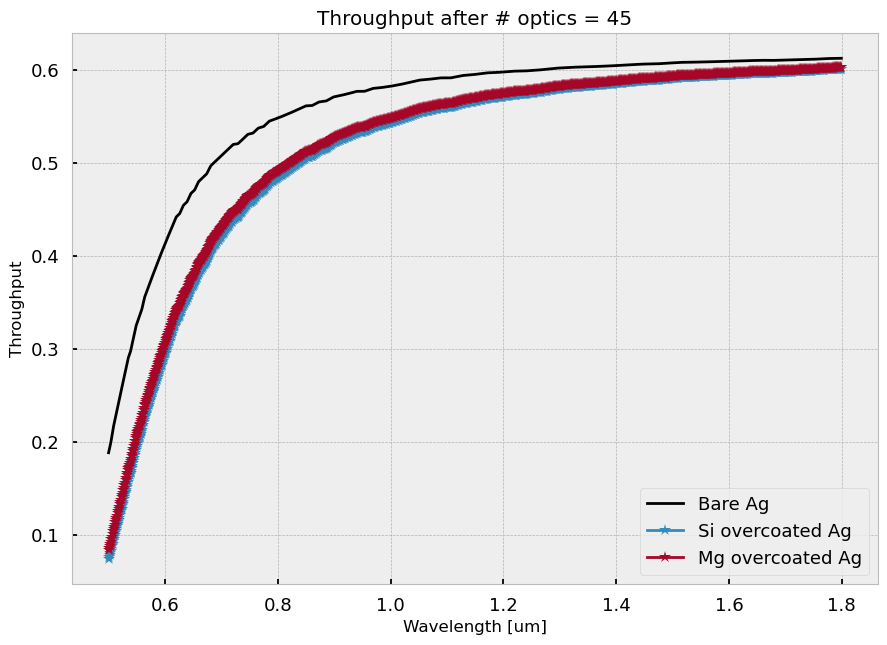

In [110]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes

plt.style.use('bmh')

# Inset 1
# axins = fig.add_axes([0.6, 0.4, 0.25, 0.25])
# PlotLines(axins)
# x1, x2, y1, y2 = 1.88, 1.95, 0.982, 0.993
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# axins.tick_params(length=0,labelleft=False, labelbottom=False)
# mark_inset(ax, axins, loc1=4, loc2=2, fc="none", ec="0",color='k',alpha=1,lw=2,zorder=10)


noptics = 45

plt.figure()
plt.title(f'Throughput after # optics = {noptics}')
plt.plot(wl,R_bare_Ag**noptics,label='Bare Ag',color='black')
plt.plot(wl,R_coated_Si**noptics,label='Si overcoated Ag',marker='*')
plt.plot(wl,R_coated_Mg**noptics,label='Mg overcoated Ag',marker='*')
# plt.plot(wl,R_coated_Ta**noptics,label='Ta overcoated Ag',marker='o')
# plt.plot(wl,R_coated_Nb**noptics,label='Nb overcoated Ag',marker='.')
plt.ylabel('Throughput')
plt.xlabel('Wavelength [um]')
plt.legend()

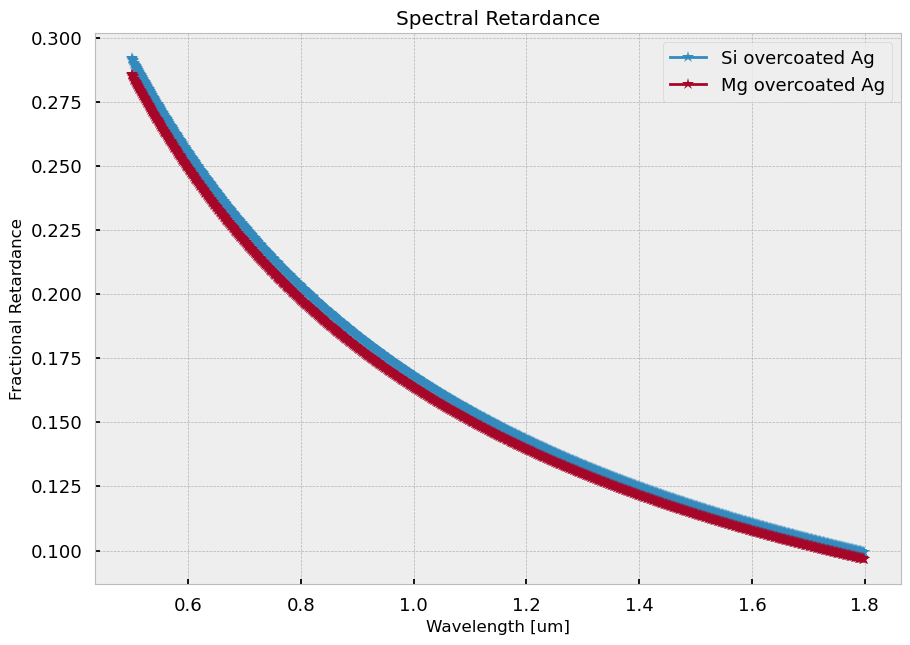

In [99]:
plt.figure()
plt.title(f'Spectral Retardance')
# plt.plot(wl,A_bare_Ag + np.pi,label='Bare Ag',color='black') # account for phase shift on reflection
plt.plot(wl,A_coated_Si/A_bare_Ag,label='Si overcoated Ag',marker='*')
plt.plot(wl,A_coated_Mg/A_bare_Ag,label='Mg overcoated Ag',marker='*')
# plt.plot(wl,R_coated_Ta**noptics,label='Ta overcoated Ag',marker='o')
# plt.plot(wl,R_coated_Nb**noptics,label='Nb overcoated Ag',marker='.')
plt.ylabel('Fractional Retardance')
plt.xlabel('Wavelength [um]')
plt.legend()

In [77]:
d_film_Mg

array([0.03278274, 0.03278274, 0.03278274, ..., 0.03278274, 0.03278274,
       0.03278274])

In [12]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']